In [1]:
%run ./Preamble.ipynb

all_models = PM.check_for_existing_patterns("activations")
# Uncomment below lines to use specific model sets:
# all_models=PM.gpt2xl_models
# all_models=PM.gpt2_models
# all_models=['gpt2','gpt2-untrained_1','gpt2-untrained_1_weight_config_all']
print(all_models)


## load preprocessed data
ys_6 = PM.load_ys(compress_to_POS_6=True, v=0) # , use_cache=False)
Xss_6 = PM.load_Xss(all_models, compress_to_POS_6=True, v=0) # , use_cache=False)
 

['gpt2-xl', 'gpt2-xl-untrained_1', 'gpt2', 'gpt2-untrained_1', 'gpt2-untrained_2', 'gpt2-untrained_3', 'gpt2-untrained_4', 'gpt2-untrained_5', 'gpt2-untrained_6', 'gpt2-untrained_7', 'gpt2-untrained_8', 'gpt2-untrained_9', 'gpt2-untrained_1_weight_config_all', 'gpt2-untrained_2_weight_config_all', 'gpt2-untrained_3_weight_config_all', 'gpt2-untrained_4_weight_config_all', 'gpt2-untrained_5_weight_config_all', 'gpt2-untrained_6_weight_config_all', 'gpt2-untrained_7_weight_config_all', 'gpt2-untrained_8_weight_config_all', 'gpt2-untrained_9_weight_config_all']


loading mydatadict:   0%|          | 0/22 [00:00<?, ?it/s]

loading models:   0%|          | 0/21 [00:00<?, ?it/s]

In [2]:
from scipy.stats import zscore

def create_splits(n1=10, n2=8, n3=5):
    """
    Create randomized splits for training, validation, and test sets.

    Args:
        n1 (int): Number of training samples.
        n2 (int): Number of validation samples.
        n3 (int): Number of test samples.

    Returns:
        list: Sorted indices for each split.
    """
    rng = np.random.default_rng(1)
    n = n1 + n2 + n3
    splits = np.split(rng.permutation(n), (n1, n1+n2))
    return [np.sort(x) for x in splits]

def generate_tvt_inds(cat_inds, tvt_splits):
    """
    Generate indices for training, validation, and test splits based on categories.

    Args:
        cat_inds (list): List of indices for each category.
        tvt_splits (list): List of splits for training, validation, and test.

    Returns:
        list: Indices for training, validation, and test sets.
    """
    choices_inds = []
    for inds in cat_inds:
        rng = np.random.default_rng(1)
        choice = rng.choice(inds, sum(len(x) for x in tvt_splits), replace=False)
        choices_inds.append(choice)
    return ([np.sort(x.take(split, axis=0)) for x in choices_inds] for split in tvt_splits)

def reduce_Xss_6(Xss_6, X_inds_set):
    """
    Reduce Xss_6 activations to the selected indices for each set.

    Args:
        Xss_6 (dict): Dictionary of activations.
        X_inds_set (list): List of indices to reduce to.

    Returns:
        dict: Reduced activations dictionary.
    """
    Xss_6_set = {}
    for model, Xs_6 in Xss_6.items():
        Xss_6_set_i = {}
        for layer, X_6 in Xs_6.items():
            list_of_values = []
            for inds in X_inds_set:
                X_6i = X_6.take(inds, axis=0).T
                list_of_values.append(X_6i)
            Xss_6_set_i[layer] = list_of_values
        Xss_6_set[model] = Xss_6_set_i
    return Xss_6_set

# Helper function to return a default value
def def_value():
    def _def_value():
        return [None] * 6
    return defaultdict(_def_value)

# Prepare data splits and reduce activations
if len(list(Xss_6.keys())):
    num_train = 200
    num_valid = 100
    num_testt = 75
    num_all = num_train + num_valid + num_testt
    
    # Create splits for train, validation, and test sets
    tvt_splits = create_splits(num_train, num_valid, num_testt)
    
    # Categorize indices based on POS tags
    cat_inds = [[i for i, v in enumerate(ys_6["POS_7_id"] == x) if v] for x in range(6)]
    
    # Generate indices for train, validation, and test sets
    X_inds_train, X_inds_valid, X_inds_test = generate_tvt_inds(cat_inds, tvt_splits)
    
    # Combine all indices and reduce activations
    all_inds = [np.sort(list(x) + list(y) + list(z)) for x, y, z in zip(X_inds_train, X_inds_valid, X_inds_test)]
    Xss_6_all = reduce_Xss_6(Xss_6, all_inds)
    
    # Clean up original activations dictionary
    for k in list(Xss_6.keys()):
        del Xss_6[k]


# Normalize activations and split them into train, validation, and test sets
if len(list(Xss_6_all.keys())):
    Xss_6_train = defaultdict(def_value)
    Xss_6_valid = defaultdict(def_value)
    Xss_6_test = defaultdict(def_value)
    
    for model, Xs_6 in Xss_6_all.items():
        for layer, X_6 in Xs_6.items():
            X_6_concat = np.concatenate(X_6, axis=1)
            zscored = zscore(X_6_concat, axis=1)
            
            for i in range(6):
                i1, i2 = num_all * i, num_all * (i + 1)
                zscored_part = zscored[:, i1:i2]
                Xss_6_train[model][layer][i] = zscored_part[:, :num_train]
                Xss_6_valid[model][layer][i] = zscored_part[:, num_train:num_train + num_valid]
                Xss_6_test[model][layer][i] = zscored_part[:, num_train + num_valid:]



In [3]:
# Helper function to calculate word frequencies
def get_counts(words_splits):
    """
    Calculate word frequencies for each split.

    Args:
        words_splits (list): List of word splits.

    Returns:
        tuple: Word counts, words, indexed words, and labels for each split.
    """
    all_counts, all_words, all_wordsi, all_labels = [], [], [], []
    
    for i, (label, split) in enumerate(zip(POS_6_tags, words_splits)):
        df = pd.DataFrame([str(x) for x in split], columns=["words"])
        counts = df.value_counts(normalize=True).head(max_n)
        words = [x for x, in counts.index]
        wordsi = [x + str(i) for x, in counts.index]
        
        all_counts.append(counts)
        all_words.append(words)
        all_wordsi.append(wordsi)
        all_labels.append(label)
    
    return all_counts, all_words, all_wordsi, all_labels


words_splits = [[ys_6["words"][i] for i in x] for x in cat_inds]


# Plot

\begin{figure}
    \centering
    \includesvg[width=\linewidth]{inputs/fig/pos6_word_categories}
    \caption{caption for fig:pos6 word categories}
    \label{fig:pos6_word_categories}
    \end{figure} % \ref{fig:pos6_word_categories}


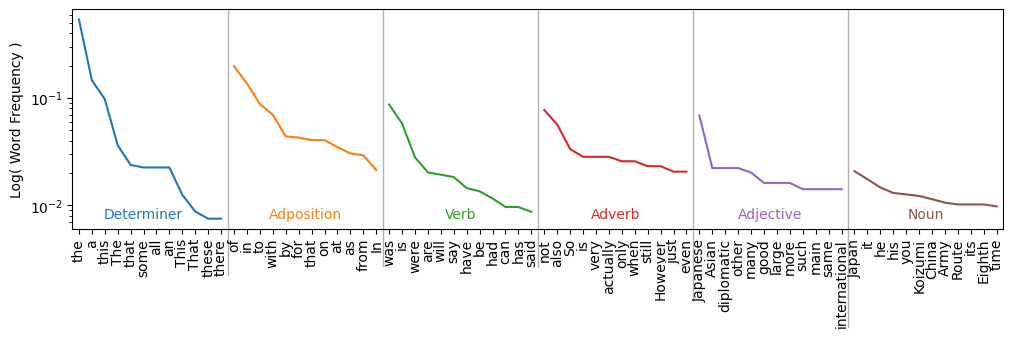

In [4]:
_=importlib.reload(my_latex_tools)
from my_latex_tools import *
_=importlib.reload(DataDisplayer)
DD = DataDisplayer.DataDisplayer(PM)

max_n=12
fig_size=(10.5, 2.5)
all_counts, all_words, all_wordsi, all_labels = get_counts(words_splits)

fig, ax = plt.subplots()
_=plt.tight_layout()
_=fig.set_size_inches(fig_size)
_=ax.set_ylabel("Log( Word Frequency )")
 
default_x_size,default_y_size=plt.rcParams.get('figure.figsize') # (6.4, 4.8)

min_y = np.min([np.min(x) for x in all_counts])
max_y = np.max([np.max(x) for x in all_counts])
sort_keys=[x[1] for x in sorted([(x[0],i) for i,x in enumerate(all_counts)],reverse=True)]
for j,i in enumerate(sort_keys):
    p=ax.semilogy(all_wordsi[i], all_counts[i],label=all_labels[i])
    if j==0:
        _=ax.text(max_n*(j+0.5)-1.0, min_y, all_labels[i],ha="center",color=p[0].get_color())
    else:
        _=ax.text(max_n*(j+0.5)-0.5, min_y, all_labels[i],ha="center",color=p[0].get_color())
_=ax.set_xticks([y for x in all_wordsi for y in x])
_=ax.set_xticklabels([y for x in all_words for y in x],rotation=90)
_=ax.set_xlim(-0.5,max_n*6-0.5)

bboxes = sorted([l.get_window_extent() for l in ax.get_xticklabels()],key=lambda x: x.xmin)
y1=ax.get_ylim()[1]
for i in range(1,6):
    text_ymin = min(bbox.ymin for bbox in bboxes[i*max_n-1:i*max_n+1])
    y0=ax.transData.inverted().transform((0,text_ymin))[1] #*0.96
    linei = mpl.lines.Line2D((i*max_n-.5,)*2,
                             ylim:=(y0,y1),
                             # ls='--',
                             lw=1.0,
                             clip_on=False,
                             color=(0,0,0,0.3))
    _=ax.add_line(linei)

save_figure_for_thesis(fig, fn='POS6_word_categories',v=1)
_=plt.show()


# Plot smol

\begin{figure}
    \centering
    \includesvg[width=\linewidth]{inputs/fig/pos6_word_categories_smol}
    \caption{caption for fig:pos6 word categories smol}
    \label{fig:pos6_word_categories_smol}
    \end{figure} % \ref{fig:pos6_word_categories_smol}


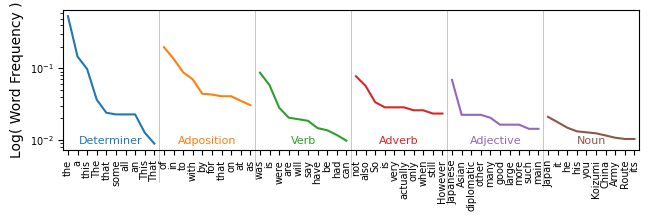

In [5]:
_=importlib.reload(my_latex_tools)
from my_latex_tools import *
_=importlib.reload(DataDisplayer)
DD = DataDisplayer.DataDisplayer(PM)

max_n=10
fig_size=(6.5, 1.6)
all_counts, all_words, all_wordsi, all_labels = get_counts(words_splits)

fig, ax = plt.subplots()
_=plt.tight_layout()
_=fig.set_size_inches(fig_size)
_=ax.set_ylabel("Log( Word Frequency )")
 
default_x_size,default_y_size=plt.rcParams.get('figure.figsize') # (6.4, 4.8)

min_y = np.min([np.min(x) for x in all_counts])
max_y = np.max([np.max(x) for x in all_counts])
sort_keys=[x[1] for x in sorted([(x[0],i) for i,x in enumerate(all_counts)],reverse=True)]
for j,i in enumerate(sort_keys):
    p=ax.semilogy(all_wordsi[i], all_counts[i],label=all_labels[i])
    _=ax.text(max_n*(j+0.5)-0.5, min_y, all_labels[i],ha="center",color=p[0].get_color(), fontsize = 8)
_=ax.set_xticks([y for x in all_wordsi for y in x])
_=ax.set_xticklabels([y for x in all_words for y in x],rotation=90, fontsize = 7)
_=ax.set_xlim(-0.5,max_n*6-0.5)
_=ax.tick_params(axis='y', labelsize=7)

bboxes = sorted([l.get_window_extent() for l in ax.get_xticklabels()],key=lambda x: x.xmin)
y1=ax.get_ylim()[1]
for i in range(1,6):
    text_ymin = min(bbox.ymin for bbox in bboxes[i*max_n-1:i*max_n+1])
    y0=ax.transData.inverted().transform((0,text_ymin))[1] #*0.96
    linei = mpl.lines.Line2D((i*max_n-.5,)*2,
                             ylim:=(y0,y1),
                             # ls='--',
                             lw=.5,
                             clip_on=False,
                             color=(0,0,0,0.3))
    _=ax.add_line(linei)
save_figure_for_thesis(fig, fn='POS6_word_categories_smol',v=1)
_=plt.show()
